In [1]:
import sys
import numpy as np
import scipy
import scipy.signal as sig
import skimage.segmentation
from matplotlib import pyplot as plt
import selectivesearch 
import matplotlib.patches as mpatches

# <font size=10 color=blue> Влияние глубокого обучения на выделение объектов </font>
![Segmentation](./img/Detection01.png)

О том, что такое mAP в детекции: https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173


![Segmentation](./img/Detection02.png)

<font color=blue size=5>Проблема:  объектов на картинке много. Что можно сделать?</font>

# <font size=10 color=blue> Region Proposals (RoI - Region of Interest) </font>

- Можно найти регионы, на которых наиболее вероятно есть объекты
- Методы, которые находять такие ригионы известны, например, Selective Search. Дает 1000 region proposals за несколько seconds на CPU
![Segmentation](./img/Detection03.png)


## <font color=blue> Image Segmentation (Felzenszwalb’s Algorithm) [Old School] </font>
_Felzenszwalb and Huttenlocher(2004)_ представили алгоритм для сегментации изображения. Изображение в данном алгоритме представляется в виде неориентированного графа $G=(V,E)$, где $v_i \in V$ - вершины графа(пиксели изображения), а $e = (v_i,v_j) \in E$ - дуги. Веса $w(v_i,v_j)$ соответствующие дугам, отражают меру непохожести между пикселями, которая может быть рассчитана по следующим параметрам:
 * Цвет
 * Положение пикселей
 * Гамма
 * Яркость
---
Решением задачи сегментации $S$ является некоторое разбиение множества $V$ на множества связанных компонент $\{C\}$. Интуитивно, разбиение должно быть таким, чтобы похожие пиксели находились в одной компоненте, а не похожие - в разных.
Варианты построения графа изображения:
 * В виде __регулярной сетки__, когда каждый пиксель соединен только с 8-ю соседями.
 * В виде __графа ближайших соседей__, когда каждый пиксель представляется в виде в виде точки в пространсте $(x,y,r,g,b)$ и с $n$ ближайшими соседями на основе Евклидова расстояния между векторами пикселей.

### Key koncepts:
 * __Internal difference__ : $Int(C) = \max_{e\in MST(C, E)} w(e)$, где $MST$ - это остовное дерево минимального веса для компоненты $\{C\}$. 
 * __Difference between two components__ : $Dif(C_1, C_2) = \min_{v_i \in C_1, v_j \in C_2, (v_i, v_j) \in E} w(v_i, v_j). Dif(C_1,C_2) = \infty$, если между двумя компонентами нету дуги.
 * __Minimum internal difference__ : $MInt(C_1, C_2) = min(Int(C_1) + \tau(C_1), Int(C_2) + \tau(C_2)), где \tau(C) = k / \vert C \vert $ - величина, ограничивающая оценку снизу. Чем выше эта величина, тем более крупными будут связные компоненты.
 * __Segmentation quality predicate__ : $D(C_1, C_2) =
\begin{cases}
  \text{True} & \text{ if } Dif(C_1, C_2) > MInt(C_1, C_2) \\
  \text{False} & \text{ otherwise}
\end{cases}$. В случае, когда предикат принимает значние $True$, мы можем рассматривать компоненты $\{C1\} и \{C2\}$, как независимые, иначе они должны быть слиты в одну.

### Алгоритм сегментации:
Дано : изображение $G=(V,E), |V|=n, |E|=m$
1. Отсортировать дуги в порядке возрастания значений их весов: $e_1, e_2, \dots, e_m$
2. Помещаем каждый пиксель в свою компоненту. Т.о. на старте алгоритма у нас $n$ независимых компонент.
3. Повторить для $k=1, \dots, m$:
    * Обозначим решение задачи сегментации для шага $k$ через $S_k$
    * Рассмотрим дугу $e_k = (v_i, v_j)$
    * Если $v_i$ и $v_j$ принадлежат одной компоненте, то $S_k = S_{k-1}$
    * Если $v_i$ и $v_j$ принадлежат разным компонентам $C_i^{k-1}$ и $C_j^{k-1}$, то в случае, если $w(v_i, v_j) \leq MInt(C_i^{k-1}, C_j^{k-1})$ мы сливаем их в одну компоненту.

/home/dk/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


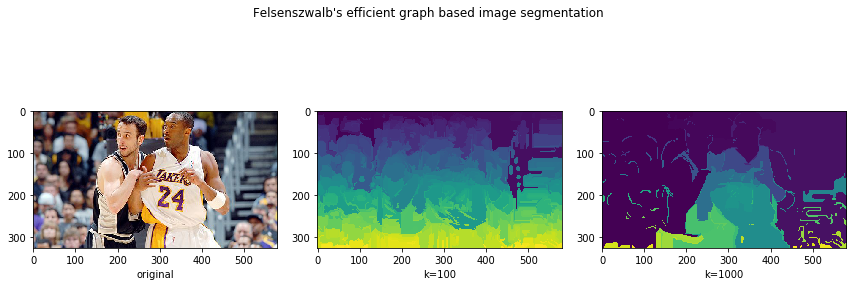

In [3]:
img2 = scipy.misc.imread("./img/nba_g_kobe_manu_580.jpg")
segment_mask1 = skimage.segmentation.felzenszwalb(img2, scale=100)
segment_mask2 = skimage.segmentation.felzenszwalb(img2, scale=1000)

fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
ax0.imshow(img2); ax0.set_xlabel("original")
ax1.imshow(segment_mask1); ax1.set_xlabel("k=100")
ax2.imshow(segment_mask2); ax2.set_xlabel("k=1000")
fig.suptitle("Felsenszwalb's efficient graph based image segmentation")
plt.tight_layout()
plt.show()

## <font color=blue> Selective Search [Old School] </font>
Классический алгоритм для поиска регионов изображения, которые потенциально содержат объекты. Для работы алгоритм использует сегментированное изображение.

---

### Алгоритм selective search:

![Segmentation](./img/sel_search.png)


/home/dk/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


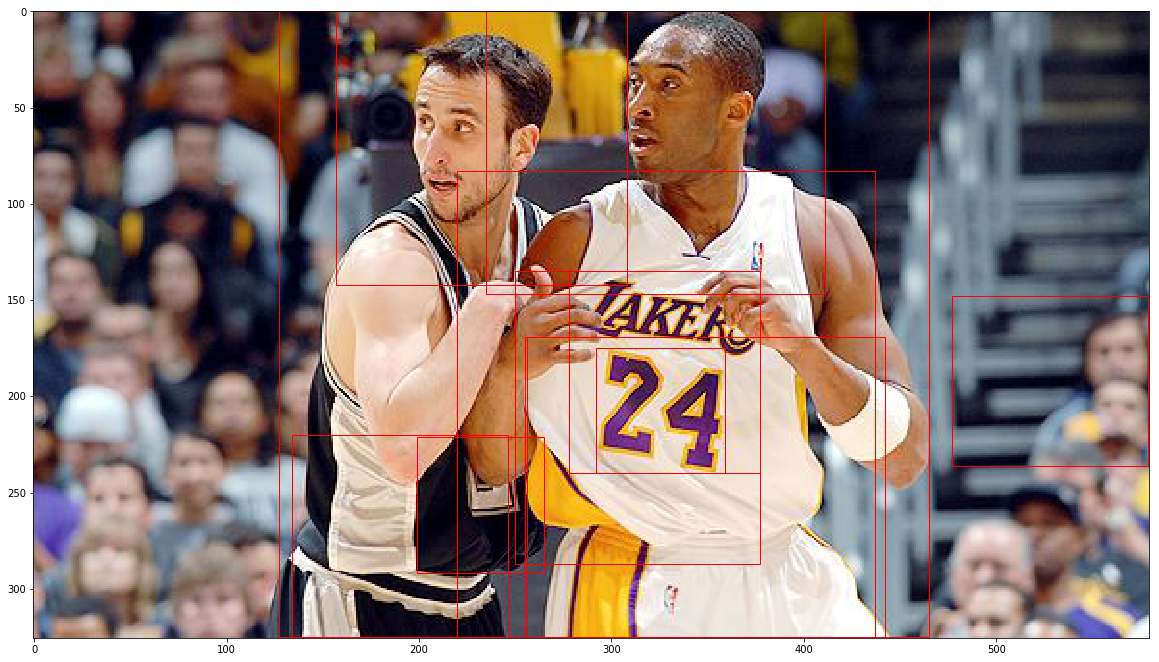

In [35]:
def do_selective_search(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=1000, sigma=0.9, min_size=10)
    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])

    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
    ax.imshow(img)
    for x, y, w, h in candidates:
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()
    return candidates

img = scipy.misc.imread("./img/nba_g_kobe_manu_580.jpg")
patch_cand = do_selective_search(img)

# <font size=10 color=blue> R-CNN </font>
![Segmentation](./img/Detection04.png)
 1. Берем предобученную на ImageNet сверточную нейронную сеть, например VGG или ResNet.
 2. При помощи SelectiveSearch отбираем регионы, на которых с наибольшей вероятностью находятся, интересующие нас, объекты ~(2k за 1-2 сек на CPU)
 3. Каждый регион трансформируем под размер входа сети и прогоняем нее.
 4. Производим fine-tuning CNN, через обучение классификатора на RoI (K + 1 класс, отвечающий за background).
 5. Фиксируем CNN и обучаем для каждого из K+1 классов binary-SVM классфикатор. В качестве позитивных примеров класса берем те RoI, для которых IoU >= 0.3
 <img src="./img/iou_equation.png" width="30%">
 6. Обучаем отдельно Bbox-regression svm по типу п.5
 ---
 * Медленное обучение
 * Много места на диске
 * Медленное предсказание
 
 --- 
 <font size=5 color=blue>Решение: делать все за один проход</font>

# <font size=10 color=blue> Fast R-CNN </font>
![Segmentation](./img/Detection05.png)
1. Берем предобученную на ImageNet сеть.
2. Изменяем сетку из п1.:
     * Выкидываем последний MaxPooling слой и заменяем его на __RoI-Pooling__ слой.
     * Выкидываем FC+SoftMax и заменяем на 2 слоя: __FC+SoftMax__(для классификации на K+1 классов), __FC__ - для предсказания bounding-box'ов.
3. При помощи SelectiveSearch отбираем регионы, на которых с наибольшей вероятностью находятся, интересующие нас, объекты ~(2k за 1-2 сек на CPU)
4. Подаем картинку и RoI  в одном батче в сеть
5. На последнем конволюционном слое находим проекцию RoI на фичемапу
6. Проекцию RoI пропускаем через RoI Pooling слой и получаем фичи, которые уже используются для классификации и построения bounding-box'а.

---

* Время работы определяется работой алгоритма для нахождения RoI 

## RoI Pooling
<img src="./img/roi_pooling.png" width="60%">

## Multi-task Loss

Модель оптимизируется при помощи multi-task loss.

---

* $u$ - истинный класс для объекта на RoI, $u \in 0, 1, \dots, K, u = 0$ для background'а
* $p$ - вероятность принадлежности RoI к $k+1$ классу $p = (p_0, \dots, p_K)$, рассчитывается при помощи softmax
* $v$ - истинная bounding-box $v = (v_x, v_y, v_w, v_h)$
* $t^u$ - bounding-box, предсказанный моделью $t^u = (t^u_x, t^u_y, t^u_w, t^u_h)$

---

Loss-функция состоит из ошибки классификации и ошибки определения b-box'а : $\mathcal{L} = \mathcal{L}_\text{cls} + \mathcal{L}_\text{box}$. При обучении, для класса $K=0$, игнорируем $\mathcal{L}_\text{box}$ посредством индикаторной функции $\mathbb{1} [u \geq 1]$.
<center>
$
\mathbb{1} [u \geq 1] = 
\begin{cases}
    1  & \text{if } u \geq 1\\
    0  & \text{otherwise}
\end{cases}
$
</center>
Таким образом общий вид лосса:
<center>
$
\begin{align*}
\mathcal{L}(p, u, t^u, v) &= \mathcal{L}_\text{cls} (p, u) + \mathbb{1} [u \geq 1] \mathcal{L}_\text{box}(t^u, v) \\
\mathcal{L}_\text{cls}(p, u) &= -\log p_u \\
\mathcal{L}_\text{box}(t^u, v) &= \sum_{i \in \{x, y, w, h\}} L_1^\text{smooth} (t^u_i - v_i)
\end{align*}
$
</center>
<center>
Где, 
$ 
L_1^\text{smooth}(x) = \begin{cases}
    0.5 x^2             & \text{if } \vert x \vert < 1\\
    \vert x \vert - 0.5 & \text{otherwise}
\end{cases}
$
</center>
<img src="./img/robust_l1_loss.png" width="30%">

## Время предсказания с учетом и без учета нахождения Region Proposals
![Segmentation](./img/Detection06.png)

# <font size=10 color=blue> Faster R-CNN </font>
![Segmentation](./img/Detection07.png)

### Архитектура

Состоит из 2 CNN сеток : 
* RPN(Region Proposal Network)
* Fast R-CNN
* Но, можно и обойтись до __одной__

### RPN Anchors

<img src="./img/Anchors.png" width="50%">

1. Окно размером 3x3, которым мы скользим по feature-map картинки.

2. Каждому положению окна на fm соответсвуют anchor'ы, которые различаются:
    * по разрешению : 128x128, 256x256, 512x512
    * по соотношению сторон : 1:1, 1:2, 2:1

Итого 9 регионов anchor'ов на одно положение окна.

### Обучение RPN

Обходим окошком(3x3) feature-map и генерируем RoI, на которых будем обучаться. В обучение берем только те RoI, для которых IoU > 0.7(positive class) и IoU < 0.3 (negative class)

### RPN Loss

Для обучения RPN так же используем multi-task loss:

\begin{align*}
\mathcal{L} &= \mathcal{L}_\text{cls} + \mathcal{L}_\text{box} \\
\mathcal{L}(\{p_i\}, \{t_i\}) &= \frac{1}{N_\text{cls}} \sum_i \mathcal{L}_\text{cls} (p_i, p^*_i) + \frac{\lambda}{N_\text{box}} \sum_i p^*_i \cdot L_1^\text{smooth}(t_i - t^*_i) \\
\end{align*}


<center>
$\mathcal{L}_\text{cls} (p_i, p^*_i) = - p^*_i \log p_i - (1 - p^*_i) \log (1 - p_i)$
</center>

Обозначения:
* $p_i$ - предсказанная вероятность, что anchor содержит объект
* $p^*_i$ - истинная вероятность, что anchor содержит объект
* $t_i$ - предсказанный вектор координат bounding box'a anchor'a
* $t^*_i$ - истинный вектор координат bounding box'a anchor'a
* $N_\text{cls}$ - нормировочный коэффициент(по кол-ву anchor'оv/размеру мини-батча) = 256(128 - positive, 128 - negative)
* $N_\text{box}$ - нормировочный коэффициент(по кол-ву расположений anchor'оv) = ~2400
* $\lambda$ - балансирующи коэффициент, для того, чтобы оба лосса имели одинаковое влияние на обучение

### Workflow тренировки всей сети
1. Берем CNN предобученную на ImageNet (СNN1)
2. Обучаем только слои RPN на фичах, сгенеренных сетью СNN1
3. Обучаем Fast R-CNN детектор на тех RoI, которые нам предсказала RPN (СNN2)
4. Дообучаем RPN-слои на фичах от сети (CNN2), при этом веса сети CNN2 зафиксированы
5. Дообучаем детектор и классификатор Fast R-CNN на регионах от RPN после п.4
6. Повторяем п.4 и п.5 до сходимости

![Segmentation](./img/Detection12.png)

# <font size=10 color=blue> Instance Segmentation </font>
---

# <font size=10 color=blue> Mask R-CNN </font>
![Segmentation](./img/Detection08.png)

Является той же самой Faster R-CNN, но в части детектора и классфикатора добавляется еще один слой, отвечающий за предсказание попиксельной маски объекта на изображении. Поскольку предсказание маски является операцией, требующей более высокой точности, то нам необходимо заменить RoIPooling слой на RoIAlign cлой.

### RoiAlign слой
Основная идея RoIAlign слоя в том, что при pooling'е границы сетки не дискретезируются.
Вместо этого, каждая ячейка "пулинга" получается одинакового размера и для вычисления значений в ячейке используется __билинейная интерполяция__.

<img src="./img/roi_align.png" width="50%">

### Loss-функция

В данной модели у нас к имеющимся loss'ам Faster R-CNN добавляется еще одна компонента: $\mathcal{L} = \mathcal{L}_\text{cls} + \mathcal{L}_\text{box} + \mathcal{L}_\text{mask}$. Для каждого RoI модель предсказывает маску размером $m\ x\ m$ для каждого из классов $K$. Таким образом мы работаем с выходом размерности $K \cdot m^2$. $\mathcal{L}_\text{mask}$ рассчитывается только для класса $k$, если последний является истиным для данного региона. 


<center>
$\mathcal{L}_\text{mask} = - \frac{1}{m^2} \sum_{1 \leq i, j \leq m} \big[ y_{ij} \log \hat{y}^k_{ij} + (1-y_{ij}) \log (1- \hat{y}^k_{ij}) \big]$,
</center>

где $y_{ij}$ это истинный класс ячейки $(i,j)$, а $\hat{y}_{ij}^k$ - вероятность класса $k$ предсказанная моделью для той же самой ячейки


# В действии
![Segmentation](./img/Detection09.png)